In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from pytorch_forecasting.metrics import SMAPE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sequence = self.data[index]
        target = self.targets[index]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

def pad_collate(batch):
    (sequences, targets) = zip(*batch)
    sequence_lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)

    # Check if targets need to be padded
    if any([len(target) != len(targets[0]) for target in targets]):
        targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    else:
        targets_padded = torch.stack(targets)

    return sequences_padded, sequence_lengths, targets_padded

In [4]:
data_dict = np.load('./data/data_dict.npy', allow_pickle=True).item()

sequence_data = data_dict['sequences']
sequence_targets = data_dict['targets']

# Create dataset
sequence_dataset = SequenceDataset(sequence_data, sequence_targets)

# Create dataloader
batch_size = 128
dataloader = DataLoader(sequence_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [16]:
class pdLSTM(nn.Module):
    def __init__(self, n_proteins, hidden_size, n_layers, n_pred):
        super(pdLSTM, self).__init__()
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(n_proteins, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_pred)
    
    def forward(self, x, device='cpu'):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # forward propagate LSTM
        x, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # decode the hidden state for each time step
        x = self.fc(x)
        x = F.relu(x)
        
        return x

In [19]:
lstm = pdLSTM(n_proteins=227, hidden_size=8, n_layers=1, n_pred=4).to(device)
opt = optim.Adam(lstm.parameters(), lr=1e-4)
loss = nn.MSELoss()
# loss = SMAPE()
loss_list = []

In [23]:
n_epochs = 10000

epoch_min = np.inf
for epoch in range(n_epochs):
    epoch_loss_list = []
    for batch_idx, (sequences_padded, sequence_lengths, targets) in enumerate(dataloader):
        opt.zero_grad()
        
        out = lstm(sequences_padded, device=device)
        
        l = loss(out, targets)
        l.backward()
        opt.step()
        epoch_loss_list.append(l.item())
    loss_list.extend(epoch_loss_list)
    if(np.mean(epoch_loss_list) < epoch_min):
        epoch_min = np.mean(epoch_loss_list)
    if(epoch % 100 == 0):
        print(f'Epoch {epoch}: {np.mean(epoch_loss_list)}')

print(f'Minimum epoch mean loss: {epoch_min}')

/var/folders/nq/bz1rt70n33n4xgr93lwcs59w0000gn/T/ipykernel_98016/978610829.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


Epoch 0: 38.27959632873535
Epoch 100: 38.37358093261719
Epoch 200: 38.20710372924805
Epoch 300: 38.35249328613281
Epoch 400: 38.22939872741699
Epoch 500: 38.06669235229492
Epoch 600: 38.071088790893555
Epoch 700: 38.11797332763672
Epoch 800: 37.9613037109375
Epoch 900: 38.157958984375
Epoch 1000: 38.04108238220215
Epoch 1100: 37.98111915588379
Epoch 1200: 37.94437217712402
Epoch 1300: 37.93365669250488
Epoch 1400: 37.74956703186035
Epoch 1500: 37.73974609375
Epoch 1600: 37.76384735107422
Epoch 1700: 37.748836517333984
Epoch 1800: 37.88768768310547
Epoch 1900: 37.80682373046875
Epoch 2000: 37.64632034301758
Epoch 2100: 37.658063888549805
Epoch 2200: 37.422733306884766
Epoch 2300: 37.72789001464844
Epoch 2400: 37.689401626586914
Epoch 2500: 37.5745735168457
Epoch 2600: 37.612213134765625
Epoch 2700: 37.62806701660156
Epoch 2800: 37.53707313537598
Epoch 2900: 37.45856285095215
Epoch 3000: 37.393802642822266
Epoch 3100: 37.588056564331055
Epoch 3200: 37.33254623413086
Epoch 3300: 37.397323

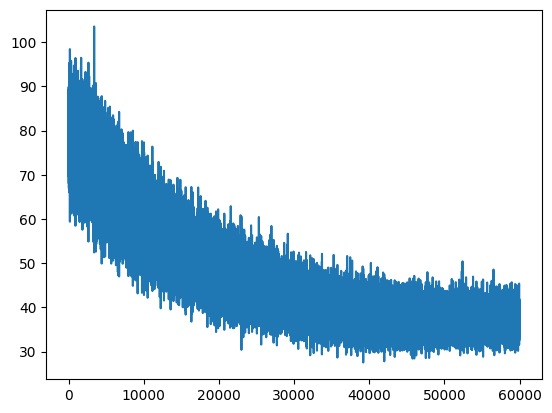

In [24]:
plt.plot(loss_list);